In [1]:
import numpy as np
import matplotlib.pylab as plt
import operator
from types import SimpleNamespace as box
from itertools import product
from functools import partial
from scipy import constants
from skimage.draw import disk

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
from parametrization import *
from viz import *

In [3]:
# Source angular frequency in Hz
omega = 2*np.pi*200e12

# Resolution in nm
dl = 25e-9

# Simulation domain size in number of pixels
size = (298, 298)

# Mode source offset from edge in pixels
# circle_radius = 190
circle_radius = 130

# The probe region should not be modified
# probe_radius = 120
probe_radius = 70

# Mode source offset from edge in pixels
src_offset = 10

# Waveguide dimensions
wg_width = 20

# Size of the PML boundaries in pixels
Npml = 6

In [4]:
params = box(
    # Number of epochs in the optimization
    epochs = 600,
    
    # Step size for the Adam optimizer
    adam_step_size = 5e-3,
    
    # Learning rate for the callback
    scheduling = {
        range(0, 301): 50,
        range(301, 600): 100,
    },
    
    # epoch when to start recording the output structures
    output_structure = 0,
    output_every = 10,
    
    # Projection parameters
    proj_n = 1,
    
    # Strength of the binarizing projection
    beta = 10,
    
    # Middle point of the binarizing projection
    eta = 0.5,
    
    # Blurring parameters
    blur_n = 1,
    blur_radius = 5,
    
    # Material penaly parameter
    penalty_weight = 1e5,
    
    # Relative permittivity
    epsr_min = 1.0,
    epsr_max = 12.0,
    
    # Min '-1' or max '+1' optimization
    direction = +1
)

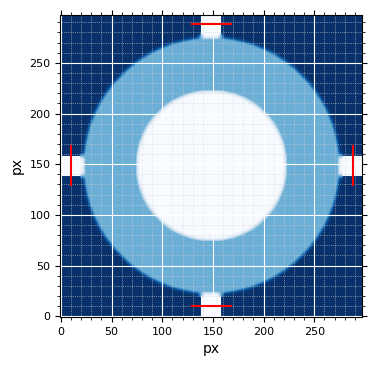

In [5]:
# Define parametrized structure
rho_init, bg_rho, design_region = (np.zeros(size) for _ in range(3))

# Place waveguides
bg_rho[:, (size[0]-wg_width)//2 : (size[1]+wg_width)//2] = 1.0
bg_rho[(size[0]-wg_width)//2 : (size[1]+wg_width)//2, :] = 1.0

# Central interference region
for radius, vals in zip([circle_radius, probe_radius], [(0, 1, .5), (1, 0, 1)]):
    r, c = disk((size[0]//2, size[1]//2), radius)

    # Overwrite waveguide coordinates where the design space will be
    bg_rho[r, c] = vals[0]
    design_region[r, c] = vals[1]
    rho_init[r, c] = vals[2]
    
# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho_init, bg_rho, design_region, params)

# Create a source in each waveguide
sources = []
source_positions = []
for conf in product((0, 1), repeat=2):
    y = np.arange(size[0]//2-20, size[1]//2+20)
    x = src_offset * np.ones(y.shape, dtype=int)
    offset, swap = conf
    if offset: x = size[0]-x
    coords = (y, x) if swap else (x, y)
    sources.append(ceviche.modes.insert_mode(omega, dl, *coords, epsr_init))
    source_positions.append(coords)

sources = sum(sources)
show_design(epsr_init, *source_positions)

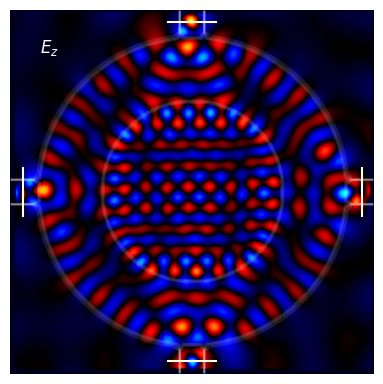

In [6]:
# Run the simulations
simulation = ceviche.fdfd_ez(omega, dl, epsr_init, 2*[Npml])
_, _, Ez_init = simulation.solve(sources)

# Visualize the field and source
show(Ez_init.real, epsr_init, sources=source_positions, theme='dark', label='$E_z$')

In [7]:
def mask(radius):
    ''' Leave only part of an array exposed '''
    r, c = disk((x//2 for x in size), radius)
    m = np.zeros(size, dtype=float)
    m[r, c] = 1
    return m

def pattern(x, y, angles, omega):
    c = 3e8
    
    n = len(angles)
 
    hs = np.zeros(x.shape)
    hc = np.zeros(y.shape)
 
    for angle in angles:
        r = np.sin(angle) * x + np.cos(angle) * y
        hs += np.sin(omega*r/c) / n
        hc += np.cos(omega*r/c) / n
 
    return hc + hs * 1j

probe_mask = mask(probe_radius+5)

In [8]:
def overlap(E1, E2):
    return npa.abs(npa.sum(npa.conj(E1) * E2))

def objective(rho, probe, E0):
    """Objective function called by optimizer"""
    rho = rho.reshape(size)
    epsr = epsr_parameterization(rho, bg_rho, design_region, params)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(sources)

    # This penalty term is the L2-norm of the raw density
    penalty = params.penalty_weight * npa.linalg.norm(rho)
    
    # The penalty term can also be directly proportional to the material area
    # penalty = penalty_weight * (design_region*(epsr-1)).sum()

    Ez *= probe_mask
    return overlap(Ez / npa.max(Ez), probe) / E0 - penalty

def callback_beta_schedule(iteration, of_list, rho):
    """Callback function for the optimizer to schedule changes to beta with the iteration number"""
    for interval, value in params.scheduling.items():
        if iteration in interval:
            params.beta = value
            break

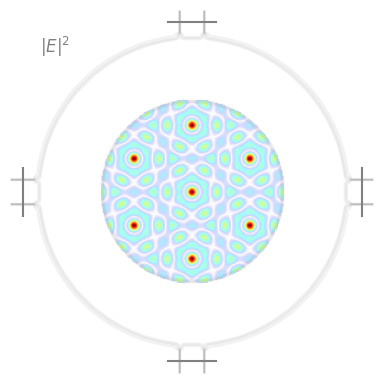

In [9]:
angles = np.angle([ 2.5-0.8660254j , -2.5-0.8660254j , -2. -1.73205081j,
                    2.5+0.8660254j , -2.5+0.8660254j ,  0.5-2.59807621j,
                   -0.5-2.59807621j,  2. -1.73205081j,  0.5+2.59807621j,
                    2. +1.73205081j, -2. +1.73205081j, -0.5+2.59807621j])

# Scale pattern according to effective wavelength
r = size[0] * dl * 1.67
X, Y = np.meshgrid(np.linspace(-r, r, size[0]),
                   np.linspace(-r, r, size[1]))

probe = pattern(X, Y, angles, omega) * probe_mask

show(np.abs(probe), epsr_init, sources=source_positions, intensity=True, label='$|E|^2$', theme='light')

In [ ]:
# Run the simulations
simulation = ceviche.fdfd_ez(omega, dl, epsr_init, 2*[Npml])
_, _, Ez_init = simulation.solve(sources)

# Maximize the objective function using an ADAM optimizer
obj = partial(objective, E0=overlap(Ez_init * probe_mask, probe), probe=probe)
(rho_optimum, loss) = adam_optimize(obj, rho_init.flatten(),
    # Compute the gradient of the objective function using reverse-mode differentiation
    jacobian(obj, mode="reverse"),

    # More parameters for the optimization
    Nsteps=params.epochs, direction='max', step_size=params.adam_step_size,

    # Function that is called before each optimization step
    callback=callback_beta_schedule)

# Simulate optimal device
rho_optimum = rho_optimum.reshape(size)
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, params)
simulation.eps_r = epsr
_, _, Ez = simulation.solve(sources)

show(np.abs(Ez), epsr, sources=sources, intensity=True, label='$|E|^2$', theme='light')

Epoch:   1/600 | Duration: 13.24 secs | Value: -1.483283e+07
Epoch:   2/600 | Duration: 13.25 secs | Value: -6.210048e+06
Epoch:   3/600 | Duration: 16.68 secs | Value: -9.567300e+06
Epoch:   4/600 | Duration: 19.22 secs | Value: -1.075756e+07
Epoch:   5/600 | Duration: 18.99 secs | Value: -4.208504e+06
Epoch:   6/600 | Duration: 19.08 secs | Value: -8.928251e+06
Epoch:   7/600 | Duration: 19.32 secs | Value: -8.420810e+06
Epoch:   8/600 | Duration: 19.20 secs | Value: -7.518474e+06
Epoch:   9/600 | Duration: 19.18 secs | Value: -6.551216e+06
Epoch:  10/600 | Duration: 19.38 secs | Value: -6.180574e+06
Epoch:  11/600 | Duration: 18.48 secs | Value: -8.426395e+06
Epoch:  12/600 | Duration: 16.08 secs | Value: -5.959709e+06
Epoch:  13/600 | Duration: 16.31 secs | Value: -2.812856e+06
Epoch:  14/600 | Duration: 16.29 secs | Value: -3.569971e+06
Epoch:  15/600 | Duration: 16.07 secs | Value: -4.270113e+06
Epoch:  16/600 | Duration: 16.25 secs | Value: -4.423863e+06
Epoch:  17/600 | Duratio